In [160]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import matplotlib

In [161]:
#warnings.filterwarnings("ignore")

In [162]:
# Import data
school_data = pd.read_csv('https://raw.githubusercontent.com/SaneSky109/DATA620/main/Data/High-School_data_2013.csv',
                          sep = ' ',
                         header = None,
                         names = ["Time_sec", "StudentID1", "StudentID2", "Class1", "Class2"])


In [163]:
attribute_data = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2013.txt',
                   sep = '\t',
                   header = None,
                   names = ["studentID", "Class", "Gender"])
attribute_data.head(5)

,studentID,Class,Gender
0,650,2BIO1,F
1,498,2BIO1,F
2,627,2BIO1,F
3,857,2BIO1,F
4,487,2BIO1,F


In [164]:
# Create Weights. Students can contact eachother multiple times in a class. Weights can capture how often the students communicate.
weighted_data = school_data.groupby(['StudentID1', 'StudentID2']).size().reset_index(name="Contacts")

# Create weights using 1/contacts to have people who are more social with eachother closer than people who hardly socialize with eachother
weighted_data["weight"] = 1 / weighted_data["Contacts"]

weighted_data.head(5)

,StudentID1,StudentID2,Contacts,weight
0,1,55,8,0.125000
1,1,63,2,0.500000
2,1,101,1,1.000000
3,1,106,4,0.250000
4,1,117,18,0.055556


In [165]:
# Randomly assign 'Gender' to unknown students
attribute_data.index[attribute_data['Gender'] == "Unknown"].tolist()

attribute_data.loc[320,'Gender'] = "F"
attribute_data.loc[321,'Gender'] = "M"
attribute_data.loc[322,'Gender'] = "F"
attribute_data.loc[323,'Gender'] = "F"
attribute_data.loc[324,'Gender'] = "M"
attribute_data.loc[325,'Gender'] = "M"
attribute_data.loc[326,'Gender'] = "M"

In [166]:
attribute_data['StudentID1'] = attribute_data['studentID']

student_nodes = pd.merge(weighted_data, attribute_data, on='StudentID1', how='inner')
student_nodes.head()

,StudentID1,StudentID2,Contacts,weight,studentID,Class,Gender
0,1,55,8,0.125000,1,2BIO3,M
1,1,63,2,0.500000,1,2BIO3,M
2,1,101,1,1.000000,1,2BIO3,M
3,1,106,4,0.250000,1,2BIO3,M
4,1,117,18,0.055556,1,2BIO3,M


In [167]:
len(student_nodes)

5818

In [168]:
g = nx.from_pandas_edgelist(student_nodes, 'StudentID1', 'StudentID2',edge_attr = True
                            , create_using = nx.DiGraph())
nx.set_node_attributes(g, student_nodes.set_index('StudentID1').to_dict('index'))

In [169]:
g.get_edge_data(106,1805)

{'Contacts': 40,
 'weight': 0.025000000000000001,
 'studentID': 106,
 'Class': '2BIO3',
 'Gender': 'F'}

In [184]:
g.node[921]

{'StudentID2': 977,
 'Contacts': 90,
 'weight': 0.011111111111111112,
 'studentID': 921,
 'Class': 'PSI*',
 'Gender': 'F'}

In [187]:
g.node[446]

{'StudentID2': 1543,
 'Contacts': 3,
 'weight': 0.3333333333333333,
 'studentID': 446,
 'Class': 'PSI*',
 'Gender': 'M'}

In [149]:
# Make types into categories
carac = student_nodes.set_index('StudentID1')
carac = student_nodes.reindex(g.nodes())

In [159]:
carac['type'] = pd.Categorical(carac['Gender'])
carac['type'].cat.codes
# Specify colors
cmap = matplotlib.colors.ListedColormap(['C0', 'darkorange'])

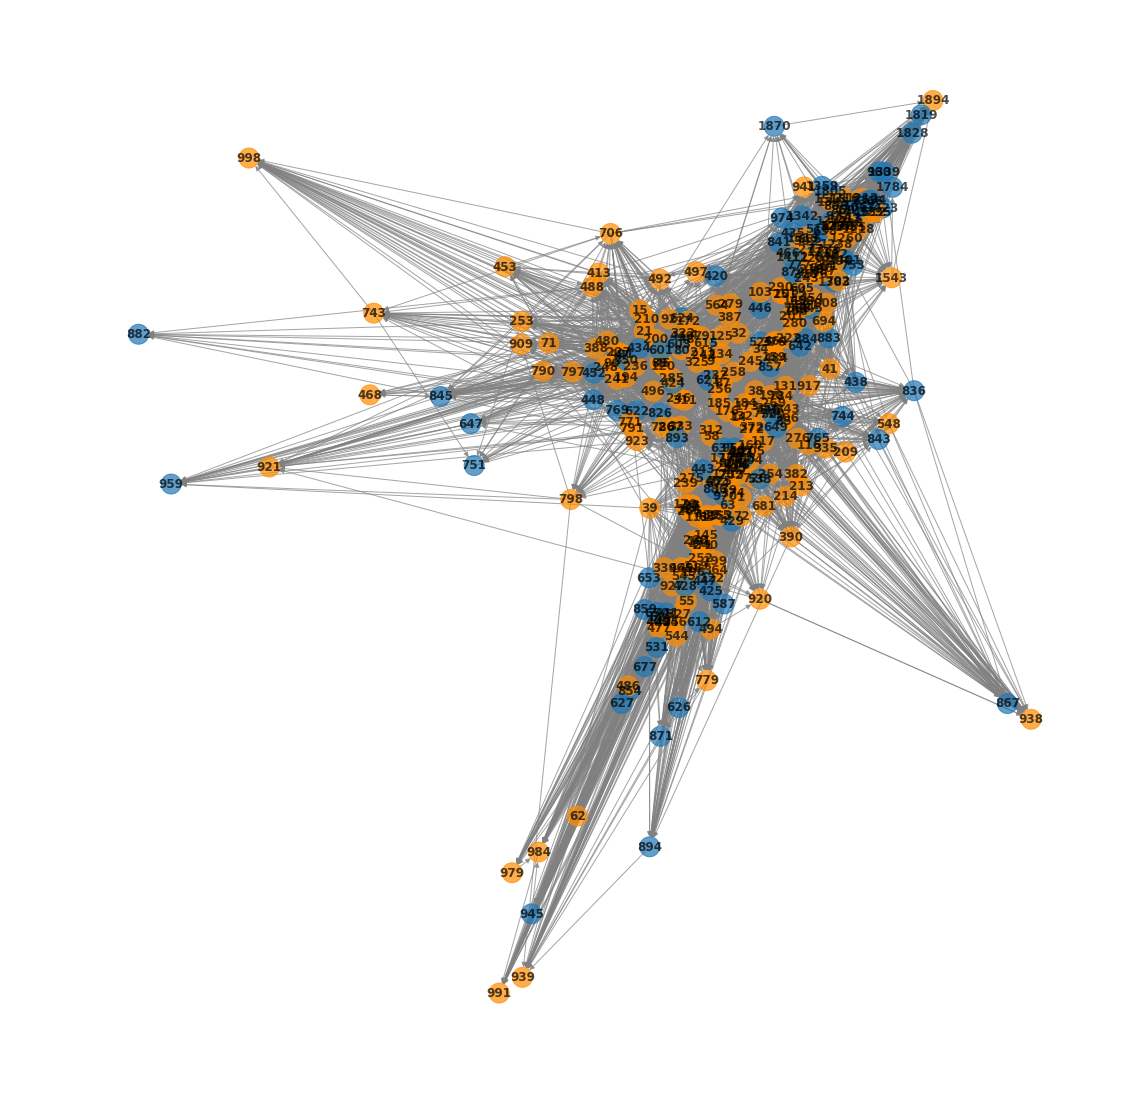

In [157]:
plt.rcParams["figure.figsize"] = (15,15)

# Draw the Graph
nx.draw(g, with_labels=True, node_size=400, node_color= carac['type'].cat.codes , cmap=cmap
        , font_weight='bold', 
edge_color="grey", alpha=0.7) 

### Degree centrality

In [214]:
d=nx.degree_centrality(g)
deg_centr = pd.DataFrame(list(d.items()), columns=['studentID', 'Deg_Centrality'])
deg_centr.head()

,studentID,Deg_Centrality
0,1,0.070552
1,55,0.085890
2,63,0.144172
3,101,0.138037
4,106,0.266871


In [218]:
deg_df = pd.merge(deg_centr, attribute_data, on = 'studentID', how='inner')
sorted_deg = deg_df.sort_values('Deg_Centrality', ascending = False)
sorted_deg.head()

,studentID,Deg_Centrality,Class,Gender,StudentID1
4,106,0.266871,2BIO3,F,106
168,1518,0.257669,MP*2,M,1518
167,1332,0.236196,MP*2,F,1332
44,272,0.233129,2BIO3,F,272
153,605,0.220859,MP,M,605


### Distribution of Degree Centrality 

In [219]:
degF = deg_df[deg_df.Gender=='F']
degM = deg_df[deg_df.Gender=='M']

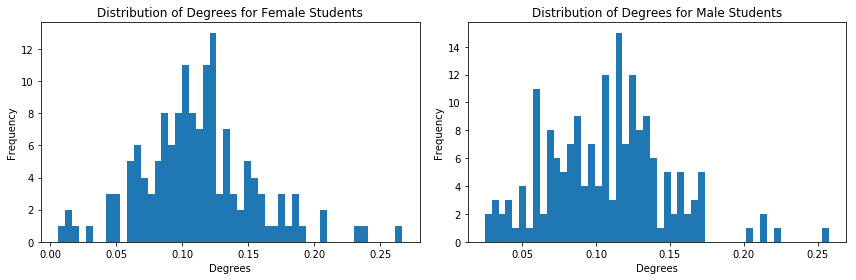

In [225]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(degF['Deg_Centrality'], 50)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees for Female Students')

plt.subplot(1, 2, 2)
plt.hist(degM['Deg_Centrality'], 50)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees for Male Students')

plt.tight_layout()
plt.show()

### Eigenvector Centrality